In [72]:
import torch
import torch.nn as nn
import pandas as pd
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.nn.utils import rnn as rnn_utils
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from gensim.utils import simple_preprocess
from gensim import corpora
from gensim.models import Word2Vec
from trainers import trainer2, trainer3, trainer4
import sys
sys.path.append('../numpy')

In [73]:
train_dataset = pd.read_csv('ag_news/train.csv')
test_dataset = pd.read_csv('ag_news/test.csv')

train_dataset.columns = ['category','title', 'news']
test_dataset.columns = ['category','title', 'news']

(train_dataset, test_dataset)

(        category                                              title  \
 0              3  Wall St. Bears Claw Back Into the Black (Reuters)   
 1              3  Carlyle Looks Toward Commercial Aerospace (Reu...   
 2              3    Oil and Economy Cloud Stocks' Outlook (Reuters)   
 3              3  Iraq Halts Oil Exports from Main Southern Pipe...   
 4              3  Oil prices soar to all-time record, posing new...   
 ...          ...                                                ...   
 119995         1  Pakistan's Musharraf Says Won't Quit as Army C...   
 119996         2                  Renteria signing a top-shelf deal   
 119997         2                    Saban not going to Dolphins yet   
 119998         2                                  Today's NFL games   
 119999         2                       Nets get Carter from Raptors   
 
                                                      news  
 0       Reuters - Short-sellers, Wall Street's dwindli...  
 1       Reu

In [74]:
tokens = []
filtered_tokens = []
mask = np.array([True] * len(train_dataset))

for i, doc in enumerate(train_dataset['news']):
    token = simple_preprocess(doc)
    tokens.append(token)
    if len(token) > 0:
        filtered_tokens.append(token)
    else:
        mask[i] = False

train_df = train_dataset[mask]

In [75]:
test_tokens = []
test_filtered_tokens = []
test_mask = np.array([True] * len(test_dataset))

for i, doc in enumerate(test_dataset['news']):
    token = simple_preprocess(doc)
    test_tokens.append(token)
    if len(token) > 0:
        test_filtered_tokens.append(token)
    else:
        test_mask[i] = False

test_df = test_dataset[test_mask]

In [76]:
dictionary = corpora.Dictionary(filtered_tokens)
dictionary.add_documents([['<UNK>']])

vocab = list(dictionary.token2id.keys())

In [77]:
embedding_dim = 100
model = Word2Vec(sentences=filtered_tokens, 
                 vector_size=embedding_dim,
                 window=5, 
                 min_count=1, 
                 workers=4,
                 sg=0)

In [78]:
embeddings = [model.wv[word] for word in vocab[:-1]]
embeddings.append(np.zeros(embedding_dim))
embeddings = np.array(embeddings)
embeddings.shape

(57655, 100)

In [79]:
X = np.array([embeddings[dictionary.doc2idx(token)].mean(axis=0)
              for token in filtered_tokens])
Y = np.array(train_df.category)
t = np.zeros((len(Y), 4))
for i, y in enumerate(Y):
    t[i, y-1] = 1

In [80]:
X_test = np.array([embeddings[dictionary.doc2idx(token)].mean(axis=0)
                   for token in test_filtered_tokens])
Y_test = np.array(test_df.category)
t_test = np.zeros((len(Y_test), 4))
for i, y in enumerate(Y_test):
    t_test[i, y-1] = 1

In [81]:
tensor_x_train = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
tensor_x_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)

tensor_y_train = torch.as_tensor(Y-1, dtype=torch.long)
tensor_y_test = torch.as_tensor(Y_test-1, dtype=torch.long)

(tensor_x_train, tensor_x_test)

(tensor([[[ 0.5495,  0.1589, -0.2610,  ..., -0.4314, -0.0114, -0.6445]],
 
         [[ 0.2327,  0.3998,  0.1668,  ..., -0.0729,  0.7252, -0.6349]],
 
         [[ 0.1252,  0.3521,  0.0035,  ..., -0.6018,  0.9027, -0.8191]],
 
         ...,
 
         [[-0.1058,  0.3163,  0.5667,  ..., -0.0910,  0.3966, -0.4991]],
 
         [[ 0.3573,  0.2050,  0.5627,  ..., -0.1595,  0.6059, -0.6430]],
 
         [[ 0.3327,  0.4561,  0.5849,  ..., -0.6337,  0.3775, -0.5900]]]),
 tensor([[[ 0.2106,  0.5581,  0.0937,  ...,  0.3653,  0.3360, -0.4727]],
 
         [[ 0.4815,  0.4477,  0.6015,  ..., -0.3799,  0.3495, -0.2285]],
 
         [[ 0.3718,  0.4796, -0.1553,  ..., -0.1171,  0.3193, -0.3922]],
 
         ...,
 
         [[ 0.1889, -0.0346,  0.7796,  ..., -0.0468,  0.8771, -0.5381]],
 
         [[ 0.0289,  0.1700,  0.5679,  ..., -0.1447,  0.9331,  0.2821]],
 
         [[ 0.1181,  0.8345,  0.2192,  ..., -0.5984,  0.5686, -0.4836]]]))

In [82]:
class RNNModel(nn.Module):
    def __init__(self, n_features, hidden_dim, n_outputs, 
                 rnn_layer=nn.LSTM, **kwargs):
        super(RNNModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_features = n_features
        self.n_outputs = n_outputs
        self.hidden = None
        self.cell = None
        self.basic_rnn = rnn_layer(self.n_features, 
                                   self.hidden_dim, 
                                   batch_first=True, 
                                   **kwargs)
        output_dim = (self.basic_rnn.bidirectional + 1) * self.hidden_dim
        self.classifier = nn.Linear(output_dim, self.n_outputs)
        
    def forward(self, X):
        is_packed = isinstance(X, nn.utils.rnn.PackedSequence)

        rnn_out, self.hidden = self.basic_rnn(X)
        if isinstance(self.basic_rnn, nn.LSTM):
            self.hidden, self.cell = self.hidden
        
        if is_packed:
            batch_first_output, seq_sizes \
                = rnn_utils.pad_packed_sequence(rnn_out, batch_first=True)        
            seq_slice = torch.arange(seq_sizes.size(0))
        else:
            batch_first_output = rnn_out
            seq_sizes = 0 
            seq_slice = slice(None, None, None) 
            
        last_output = batch_first_output[seq_slice, seq_sizes-1]
        
        out = self.classifier(last_output)
                
        return out.view(-1, self.n_outputs)

In [83]:
train_data = TensorDataset(tensor_x_train, tensor_y_train)
train_loader = DataLoader(train_data,
                          batch_size=100,
                          shuffle=True, 
                          drop_last=True,
                          generator=torch.Generator())

test_data = TensorDataset(tensor_x_test, tensor_y_test)
test_loader = DataLoader(test_data,
                          batch_size=100,
                          shuffle=True, 
                          drop_last=True,
                          generator=torch.Generator())


model = RNNModel(n_features=100, hidden_dim=100, n_outputs=4,
                 rnn_layer=nn.LSTM, num_layers=2, bidirectional=True)
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [84]:
sbs_one = trainer2(model, loss, optimizer)
sbs_one.set_loaders(train_loader)
sbs_one.train(150)

In [85]:
trainer2.loader_apply(test_loader, sbs_one.correct)

tensor([[1650, 1900],
        [1804, 1900],
        [1535, 1900],
        [1555, 1900]])

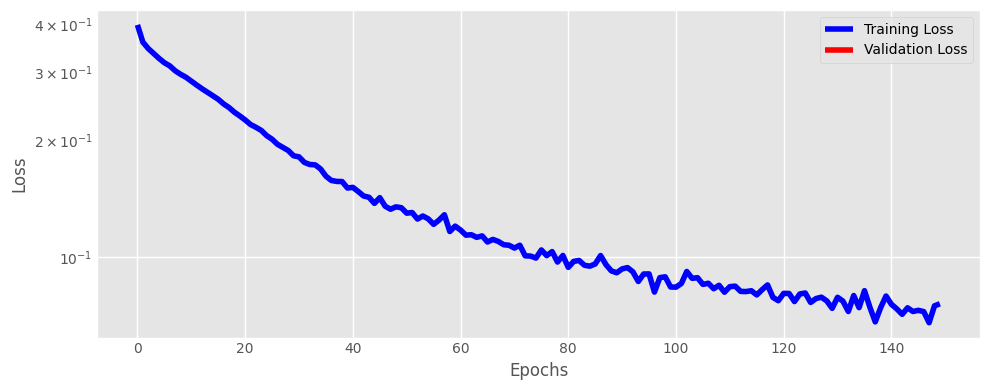

In [86]:
fig = sbs_one.plot_losses()